In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import seaborn as sns

# Predicting House Sale Prices
<p> Using linear regression, I will build a model to predict house sale prices with housing data for the city of Ames, Iowa, United States from 2006 to 2010. The data can be found <a href="https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627">here</a>.</p>

In [2]:
def transform_features(df):
    #more than 25% of values are NaN
    vc_per = (df.isnull().sum()[df.isnull().sum()>0]/df.shape[0])
    cols_drop = vc_per[vc_per >0.25].index
    df.drop(columns = cols_drop, inplace = True)
    
    #numerical values with NaN
    numerical_nan = df.select_dtypes(include = ['int','float']).isnull().sum()
    numerical_nan[numerical_nan >0]
    num_nan_col = numerical_nan[numerical_nan >0].index
    df[num_nan_col] = df[num_nan_col].fillna(df[num_nan_col].mean())
    #object values with NaN:
    obj_nan = df.select_dtypes(include = ['object']).isnull().sum()
    replacement_values_dict = df[obj_nan[obj_nan >0].index].mode().to_dict(orient='records')[0]
    df[obj_nan[obj_nan >0].index] = df[obj_nan[obj_nan >0].index].fillna(replacement_values_dict)
    
    #drop columns with no variety in values:
    over85 = []
    for col in obj_nan[obj_nan >0].index:
        if df[col].value_counts(normalize = True)[0]>0.85:
            over85.append(col)
    df.drop(columns = over85, inplace = True)

    #columns with years:
    df['garage age'] = df['Yr Sold'] - df['Garage Yr Blt']
    df['years till remod/add'] = df['Year Remod/Add'] - df['Year Built']
    df['years till sold'] = df['Yr Sold'] - df['Year Built']
    df['years remod till sold'] = df['Yr Sold'] - df['Year Remod/Add']
    df.drop(columns = ['Year Remod/Add','Year Built','Garage Yr Blt'],inplace = True)
    df = df[(df['years till remod/add']>0) & 
                (df['years till sold']>0) &
                (df['years remod till sold']>0)
               ].copy()
    
    #useless columns or columns that leak data about the final sale:
    useless = ['PID','Order']
    leak = ['Mo Sold','Sale Condition','Sale Type','Yr Sold']
    df.drop(columns = useless, inplace = True)
    df.drop(columns = leak, inplace = True)
    return df

def select_features(df, corr_thr):
    #transform text columns to categorical columns:
    for col in df.select_dtypes(include = ['object']).columns:
        df[col] = df[col].astype('category')
    #list of more categorical columns:
    nominal_cols = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    #converting all to categorical columns:
    for col in nominal_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
            
    #drop columns with more than 10 unique categorical values
    vc_unique = df.select_dtypes(include = ['category']).apply(lambda x : len(x.value_counts())).sort_values()
    to_drop = vc_unique[vc_unique>10].index
    df.drop(columns = to_drop, inplace = True)
  
    #correlation:
    num_houses = df.select_dtypes(include = ['int','float'])
    corrmat = num_houses.corr()
    vc = np.abs(corrmat['SalePrice']).sort_values()
    corr_df = df[vc[vc>corr_thr].index].copy()
    
    #dummy columns:
    cat_cols = df.select_dtypes(include = ['category']).columns
    updated_df = pd.concat([
        corr_df,
        pd.get_dummies(df.select_dtypes(include = ['category']))
    ],axis =1)
    return updated_df

def train_and_test(df,k):
    df = df.sample(frac=1).reset_index(drop=True)
    idx = round(df.shape[0]*0.75)
    if k == 0:    
        train = df[:idx]
        test = df[idx:]
        lr.fit(train[features],train[target])
        predictions = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test[target],predictions))
        return rmse
    elif k == 1:
        train = df[:idx]
        test = df[idx:]

        lr.fit(train[features],train[target])
        predictions_1 = lr.predict(test[features])
        rmse_1 = np.sqrt(mean_squared_error(test[target],predictions_1))

        lr.fit(test[features],test[target])
        predictions_2 = lr.predict(train[features])
        rmse_2 = np.sqrt(mean_squared_error(train[target],predictions_2))
        avg_rmse = np.mean([rmse_1,rmse_2])
        return avg_rmse
    else:
        kf = KFold(n_splits = k, shuffle = True)
        rmses = []
        for tr_idx, tst_idx in kf.split(df):
            train = df.iloc[tr_idx]
            test = df.iloc[tst_idx]
            lr.fit(train[features],train[target])
            prediction = lr.predict(test[features])
            rmse = np.sqrt(mean_squared_error(test[target],prediction))
            rmses.append(rmse)
        avg_rmse = np.mean(rmses)
        return avg_rmse

In [3]:
houses = pd.read_csv('AmesHousing.tsv',sep = '\t')
houses.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Dealing with missing values:

What are the columns with missing values? I counted the missing values, filtered for columns that have at least one missing value and divided the number of missing values by the total number or rows. It displays now the percentage of values that are `NaN`s:

In [4]:
(houses.isnull().sum()[houses.isnull().sum()>0]/houses.shape[0]*100).sort_values()

Electrical         0.034130
Garage Area        0.034130
Total Bsmt SF      0.034130
Bsmt Unf SF        0.034130
BsmtFin SF 1       0.034130
BsmtFin SF 2       0.034130
Garage Cars        0.034130
Bsmt Full Bath     0.068259
Bsmt Half Bath     0.068259
Mas Vnr Area       0.784983
Mas Vnr Type       0.784983
BsmtFin Type 1     2.730375
Bsmt Qual          2.730375
Bsmt Cond          2.730375
BsmtFin Type 2     2.764505
Bsmt Exposure      2.832765
Garage Type        5.358362
Garage Finish      5.426621
Garage Qual        5.426621
Garage Cond        5.426621
Garage Yr Blt      5.426621
Lot Frontage      16.723549
Fireplace Qu      48.532423
Fence             80.477816
Alley             93.242321
Misc Feature      96.382253
Pool QC           99.556314
dtype: float64

I will drop any feature with more than 25% of `NaN`. The function `transform_features()` is updated accordingly.

In [5]:
vc_per = (houses.isnull().sum()[houses.isnull().sum()>0]/houses.shape[0])
cols_drop = vc_per[vc_per >0.25].index
houses.drop(columns = cols_drop, inplace = True)

The other `Nan` of numerical columns will be substituted by the mean of the column: 

In [6]:
numerical_nan = houses.select_dtypes(include = ['int','float']).isnull().sum()
num_index = numerical_nan[numerical_nan >0].index
houses[num_index].head()

,Lot Frontage,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area
0,141.0,112.0,639.0,0.0,441.0,1080.0,1.0,0.0,1960.0,2.0,528.0
1,80.0,0.0,468.0,144.0,270.0,882.0,0.0,0.0,1961.0,1.0,730.0
2,81.0,108.0,923.0,0.0,406.0,1329.0,0.0,0.0,1958.0,1.0,312.0
3,93.0,0.0,1065.0,0.0,1045.0,2110.0,1.0,0.0,1968.0,2.0,522.0
4,74.0,0.0,791.0,0.0,137.0,928.0,0.0,0.0,1997.0,2.0,482.0


The column `houses['Garage Yr Blt']` needs to be updated. Best to use "age of garage when sold":

In [7]:
houses['garage age'] = houses['Yr Sold'] - houses['Garage Yr Blt']
houses.drop(columns = ['Garage Yr Blt'],inplace = True)

In [8]:
numerical_nan = houses.select_dtypes(include = ['int','float']).isnull().sum()
numerical_nan[numerical_nan >0]

Lot Frontage      490
Mas Vnr Area       23
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Cars         1
Garage Area         1
garage age        159
dtype: int64

In [9]:
num_nan_col = numerical_nan[numerical_nan >0].index
houses[num_nan_col] = houses[num_nan_col].fillna(houses[num_nan_col].mean())

In [10]:
houses[num_nan_col].isnull().sum()

Lot Frontage      0
Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Cars       0
Garage Area       0
garage age        0
dtype: int64

Columns with `objects` and missing values:

In [11]:
obj_nan = houses.select_dtypes(include = ['object']).isnull().sum()
obj_nan[obj_nan >0]

Mas Vnr Type       23
Bsmt Qual          80
Bsmt Cond          80
Bsmt Exposure      83
BsmtFin Type 1     80
BsmtFin Type 2     81
Electrical          1
Garage Type       157
Garage Finish     159
Garage Qual       159
Garage Cond       159
dtype: int64

In [12]:
houses[obj_nan[obj_nan >0].index].head()

,Mas Vnr Type,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Electrical,Garage Type,Garage Finish,Garage Qual,Garage Cond
0,Stone,TA,Gd,Gd,BLQ,Unf,SBrkr,Attchd,Fin,TA,TA
1,None,TA,TA,No,Rec,LwQ,SBrkr,Attchd,Unf,TA,TA
2,BrkFace,TA,TA,No,ALQ,Unf,SBrkr,Attchd,Unf,TA,TA
3,None,TA,TA,No,ALQ,Unf,SBrkr,Attchd,Fin,TA,TA
4,None,Gd,TA,No,GLQ,Unf,SBrkr,Attchd,Fin,TA,TA


In [13]:
over85 = []
for col in obj_nan[obj_nan >0].index:
    print(houses[col].value_counts(normalize = True,dropna = False))
    if houses[col].value_counts(normalize = True)[0]>0.85:
        over85.append(col)

None       0.597952
BrkFace    0.300341
Stone      0.084983
BrkCmn     0.008532
NaN        0.007850
CBlock     0.000341
Name: Mas Vnr Type, dtype: float64
TA     0.437884
Gd     0.416041
Ex     0.088055
Fa     0.030034
NaN    0.027304
Po     0.000683
Name: Bsmt Qual, dtype: float64
TA     0.892833
Gd     0.041638
Fa     0.035495
NaN    0.027304
Po     0.001706
Ex     0.001024
Name: Bsmt Cond, dtype: float64
No     0.650512
Av     0.142662
Gd     0.096928
Mn     0.081570
NaN    0.028328
Name: Bsmt Exposure, dtype: float64
GLQ    0.293174
Unf    0.290444
ALQ    0.146416
Rec    0.098294
BLQ    0.091809
LwQ    0.052560
NaN    0.027304
Name: BsmtFin Type 1, dtype: float64
Unf    0.852901
Rec    0.036177
LwQ    0.030375
NaN    0.027645
BLQ    0.023208
ALQ    0.018089
GLQ    0.011604
Name: BsmtFin Type 2, dtype: float64
SBrkr    0.915358
FuseA    0.064164
FuseF    0.017065
FuseP    0.002730
Mix      0.000341
NaN      0.000341
Name: Electrical, dtype: float64
Attchd     0.590785
Detchd     0.2

Some of these columns have mostly the same value. For example in `Garage Qual` over 90% of all entries are `TA`. For now I will drop every column with more than 85% of one value. I might take them into account again later and test whether they improve the result.

In [14]:
houses.drop(columns = over85, inplace = True)

In [15]:
obj_nan = houses.select_dtypes(include = ['object']).isnull().sum()
houses[obj_nan[obj_nan >0].index].head()

,Mas Vnr Type,Bsmt Qual,Bsmt Exposure,BsmtFin Type 1,Garage Type,Garage Finish
0,Stone,TA,Gd,BLQ,Attchd,Fin
1,None,TA,No,Rec,Attchd,Unf
2,BrkFace,TA,No,ALQ,Attchd,Unf
3,None,TA,No,ALQ,Attchd,Fin
4,None,Gd,No,GLQ,Attchd,Fin


I will fill the `NaN` with the most common entry:

In [16]:
replacement_values_dict = houses[obj_nan[obj_nan >0].index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'Bsmt Exposure': 'No',
 'Bsmt Qual': 'TA',
 'BsmtFin Type 1': 'GLQ',
 'Garage Finish': 'Unf',
 'Garage Type': 'Attchd',
 'Mas Vnr Type': 'None'}

In [17]:
houses[obj_nan[obj_nan >0].index] = houses[obj_nan[obj_nan >0].index].fillna(replacement_values_dict)
houses[obj_nan[obj_nan >0].index].isnull().sum()

Mas Vnr Type      0
Bsmt Qual         0
Bsmt Exposure     0
BsmtFin Type 1    0
Garage Type       0
Garage Finish     0
dtype: int64

Are the `NaN` really gone?

In [18]:
houses.isnull().sum().sort_values()

Order              0
TotRms AbvGrd      0
Kitchen Qual       0
Kitchen AbvGr      0
Bedroom AbvGr      0
Half Bath          0
Full Bath          0
Functional         0
Bsmt Half Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Central Air        0
Heating QC         0
Bsmt Full Bath     0
Heating            0
Fireplaces         0
Garage Finish      0
Sale Condition     0
Sale Type          0
Yr Sold            0
Mo Sold            0
Misc Val           0
Pool Area          0
Garage Type        0
Screen Porch       0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
                  ..
Utilities          0
Bldg Type          0
Land Contour       0
Street             0
Lot Area           0
Lot Frontage       0
MS Zoning          0
MS SubClass        0
PID                0
Lot Shape          0
House Style        0
Overall Qual       0
Overall Cond       0
BsmtFin SF 1       0
BsmtFin Type 1     0
Bsmt Exposure      0
Bsmt Qual    

The next step is to look for columns that need to be modified. For example categorical features or numerical (non-categorical) features that need to be improved. More information about the columns can be found <a href="https://s3.amazonaws.com/dq-content/307/data_description.txt">here</a>.

In [19]:
houses.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,garage age
0,1,526301100,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,...,0,0,0,0,5,2010,WD,Normal,215000,50.0
1,2,526350040,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,...,0,120,0,0,6,2010,WD,Normal,105000,49.0
2,3,526351010,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,...,0,0,0,12500,6,2010,WD,Normal,172000,52.0
3,4,526353030,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,...,0,0,0,0,4,2010,WD,Normal,244000,42.0
4,5,527105010,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,...,0,0,0,0,3,2010,WD,Normal,189900,13.0


In [20]:
houses['years till remod/add'] = houses['Year Remod/Add'] - houses['Year Built']
houses['years till sold'] = houses['Yr Sold'] - houses['Year Built']
houses['years remod till sold'] = houses['Yr Sold'] - houses['Year Remod/Add']
houses.drop(columns = ['Year Remod/Add','Year Built'],inplace = True)

In [21]:
houses['years till remod/add'].min()

-1

In [22]:
houses['years till sold'].min()

-1

In [23]:
[(houses['years till remod/add']<0).sum(),
 (houses['years till sold']<0).sum(),
 (houses['years remod till sold']<0).sum()
]

[1, 1, 3]

These values are obviously wrong.

In [24]:
houses = houses[(houses['years till remod/add']>0) & 
                (houses['years till sold']>0) &
                (houses['years remod till sold']>0)
               ].copy()

Which columns will not be useful for ML? Which columns leak info about the final sale?

In [25]:
useless = ['PID','Order']
leak = ['Mo Sold','Sale Condition','Sale Type','Yr Sold']
houses.drop(columns = useless, inplace = True)
houses.drop(columns = leak, inplace = True)

Which columns are categorical?

In [26]:
houses.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,garage age,years till remod/add,years till sold,years remod till sold
4,60,RL,74.00000,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,189900,13.0,1,13,12
8,120,RL,39.00000,5389,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,236500,15.0,1,15,14
10,60,RL,75.00000,10000,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,175900,17.0,1,17,16
11,20,RL,69.22459,7980,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,500,185000,18.0,15,18,3
16,50,RL,152.00000,12134,Pave,IR1,Bnk,AllPub,Inside,Mod,...,0,0,0,0,0,164000,22.0,17,22,5


In [27]:
houses.select_dtypes(include = ['object']).head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Bsmt Exposure,BsmtFin Type 1,Heating,Heating QC,Central Air,Kitchen Qual,Functional,Garage Type,Garage Finish,Paved Drive
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,No,GLQ,GasA,Gd,Y,TA,Typ,Attchd,Fin,Y
8,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,No,GLQ,GasA,Ex,Y,Gd,Typ,Attchd,RFn,Y
10,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,...,No,Unf,GasA,Gd,Y,TA,Typ,Attchd,Fin,Y
11,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,No,ALQ,GasA,Ex,Y,TA,Typ,Attchd,Fin,Y
16,RL,Pave,IR1,Bnk,AllPub,Inside,Mod,Gilbert,Norm,Norm,...,Av,GLQ,GasA,Gd,Y,TA,Typ,Basment,RFn,Y


In [28]:
for col in houses.select_dtypes(include = ['object']).columns:
    houses[col] = houses[col].astype('category')

In [29]:
houses.select_dtypes(include = ['int','float']).head()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,garage age,years till remod/add,years till sold,years remod till sold
4,60,74.00000,13830,5,5,0.0,791.0,0.0,137.0,928.0,...,0,0,0,0,0,189900,13.0,1,13,12
8,120,39.00000,5389,8,5,0.0,1180.0,0.0,415.0,1595.0,...,0,0,0,0,0,236500,15.0,1,15,14
10,60,75.00000,10000,6,5,0.0,0.0,0.0,763.0,763.0,...,0,0,0,0,0,175900,17.0,1,17,16
11,20,69.22459,7980,6,7,0.0,935.0,0.0,233.0,1168.0,...,0,0,0,0,500,185000,18.0,15,18,3
16,50,152.00000,12134,8,7,0.0,427.0,0.0,132.0,559.0,...,0,0,0,0,0,164000,22.0,17,22,5


According to the documentation, these are nominal columns:

In [30]:
nominal_cols = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

Some of these are numerical, so I will need to change them to categorical as well:

In [31]:
for col in nominal_cols:
    if col in houses.columns:
        houses[col] = houses[col].astype('category')

How many unique values do the categorical columns have?

In [32]:
houses.select_dtypes(include = ['category']).apply(lambda x : len(x.value_counts())).sort_values()

Street             2
Utilities          2
Central Air        2
Paved Drive        3
Land Slope         3
Garage Finish      3
Lot Shape          4
Land Contour       4
Bsmt Exposure      4
Exter Qual         4
Mas Vnr Type       4
Heating QC         5
Bsmt Qual          5
Exter Cond         5
Roof Style         5
Bldg Type          5
Lot Config         5
Kitchen Qual       5
Condition 2        6
Foundation         6
Garage Type        6
BsmtFin Type 1     6
Heating            6
MS Zoning          6
Roof Matl          6
House Style        8
Functional         8
Condition 1        9
MS SubClass       16
Exterior 2nd      16
Exterior 1st      16
Neighborhood      26
dtype: int64

A bit arbitrary I will drop the columns with more than 10 different uniwue values:

In [33]:
vc_unique = houses.select_dtypes(include = ['category']).apply(lambda x : len(x.value_counts())).sort_values()
to_drop = vc_unique[vc_unique>10].index
houses.drop(columns = to_drop, inplace = True)

I will create dummy columns to add to the dataframe `houses`later after looking for correlations.

## Correlations and feature selection:

In [34]:
num_houses = houses.select_dtypes(include = ['int','float'])

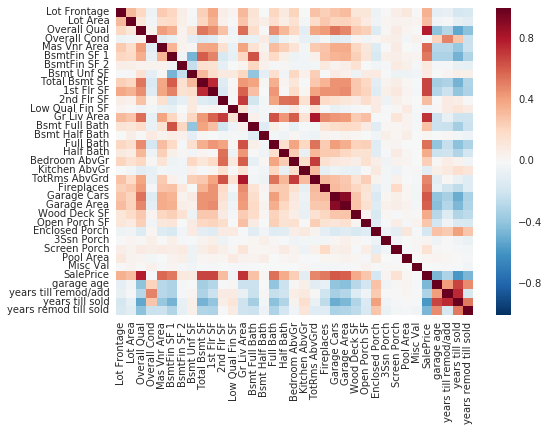

In [35]:
corrmat = num_houses.corr()
sns.heatmap(corrmat)

In [36]:
vc = np.abs(corrmat['SalePrice']).sort_values()
vc

Misc Val                 0.001168
Overall Cond             0.013940
Bsmt Half Bath           0.018517
Pool Area                0.019769
3Ssn Porch               0.028839
Low Qual Fin SF          0.032487
Bsmt Unf SF              0.088993
BsmtFin SF 2             0.096245
Kitchen AbvGr            0.104223
Screen Porch             0.150711
Enclosed Porch           0.178833
Bedroom AbvGr            0.244807
Open Porch SF            0.277530
Bsmt Full Bath           0.290527
2nd Flr SF               0.311475
years till remod/add     0.311580
Lot Area                 0.312232
Lot Frontage             0.355076
Half Bath                0.370833
Wood Deck SF             0.375763
garage age               0.448418
years remod till sold    0.459868
TotRms AbvGrd            0.487044
Fireplaces               0.523713
BsmtFin SF 1             0.524783
Full Bath                0.554539
Mas Vnr Area             0.571951
years till sold          0.578514
Garage Area              0.600539
Garage Cars   

In [37]:
corr_houses = houses[vc[vc>0.4].index].copy()

In [38]:
cat_cols = houses.select_dtypes(include = ['category']).columns
updated_houses = pd.concat([
    corr_houses,
    pd.get_dummies(houses.select_dtypes(include = ['category']))
],axis =1)

Ultimately, I will use the functions I have defined in the beginning. I will add an argument of what is the lowest correlation allowed and will be able to test different thresholds.

## train and test
<p>Now I will set up the pipeline for the training and testing of models:</p>

In [39]:
target = 'SalePrice'
features = updated_houses.columns.drop(target)
numeric_houses = updated_houses.select_dtypes(include = ['int','float'])
lr = LinearRegression()

In the function `train_and_test`, there will be an argument `k`, which determines what kind of validation will be performed:
<ul>
<li> k=0: holdout validation </li>
<li> k=1: simple cross validation</li>
<li> k>1 and k!=1: k-fold cross validation</li>
</ul>

In [40]:
k = 1
idx = round(updated_houses.shape[0]*0.75)
if k == 0:    
    train = updated_houses[:idx]
    test = updated_houses[idx:]
    lr.fit(train[features],train[target])
    predictions = lr.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test[target],predictions))
elif k == 1:
    shuffled_houses = updated_houses.sample(frac=1).reset_index(drop = True)
    train = shuffled_houses[:idx]
    test = shuffled_houses[idx:]
    
    lr.fit(train[features],train[target])
    predictions_1 = lr.predict(test[features])
    rmse_1 = np.sqrt(mean_squared_error(test[target],predictions_1))
    
    lr.fit(test[features],test[target])
    predictions_2 = lr.predict(train[features])
    rmse_2 = np.sqrt(mean_squared_error(train[target],predictions_2))
    avg_rmse = np.mean([rmse_1,rmse_2])
else:
    kf = KFold(n_splits = k, shuffle = True)
    rmses = []
    for tr_idx, tst_idx in kf.split(updated_houses):
        train = updated_houses.iloc[tr_idx]
        test = updated_houses.iloc[tst_idx]
        lr.fit(train[features],train[target])
        prediction = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test[target],prediction))
        rmses.append(rmse)
    avg_rmse = np.mean(rmses)

In [41]:
avg_rmse

27464.06072668155

## testing the pipeline:

In [42]:
house = pd.read_csv("AmesHousing.tsv", delimiter="\t")
trans_house = transform_features(house)
filtered_house = select_features(trans_house, 0.4)
rmse = train_and_test(filtered_house, k=5)
rmse

24011.65329745602

Now I can test a few values:

In [43]:
house = pd.read_csv("AmesHousing.tsv", delimiter="\t")
trans_house = transform_features(house)
filtered_house = select_features(trans_house, 0.4)
rmse = train_and_test(filtered_house, k=0)
rmse

25284.119522520003

In [45]:
house = pd.read_csv("AmesHousing.tsv", delimiter="\t")
trans_house = transform_features(house)
filtered_house = select_features(trans_house, 0.4)
rmse = train_and_test(filtered_house, k=1)
rmse

25292.075173835976

k-fold attribution seems to work better than holdout validation and simple cross validation. Which k ist the best?

In [55]:
k_dict = {}
for kk in range(3,20):
    house = pd.read_csv("AmesHousing.tsv", delimiter="\t")
    trans_house = transform_features(house)
    filtered_house = select_features(trans_house, 0.4)
    rmse = train_and_test(filtered_house, k=kk)
    k_dict[kk]=rmse
print(k_dict)

{3: 24530.03986933577, 4: 24325.162253015886, 5: 23925.163178559225, 6: 23426.811919852025, 7: 24371.184312747442, 8: 23851.242949942898, 9: 23802.083081617573, 10: 23483.563936092844, 11: 23521.607376921027, 12: 23286.427928118515, 13: 23930.02685174824, 14: 23771.003061990512, 15: 23423.86490743945, 16: 23522.375877790826, 17: 23751.656359805285, 18: 23461.239061607874, 19: 23669.061460495097}


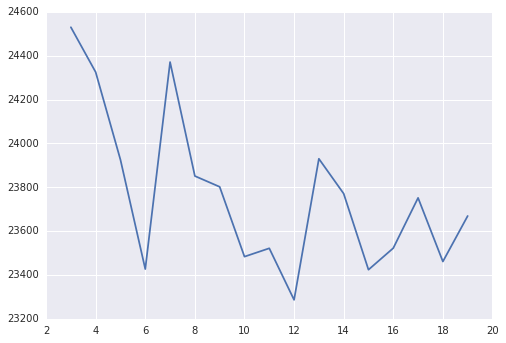

In [56]:
plt.plot(list(k_dict.keys()),list(k_dict.values()))

It seems k = 12 is particularly well working.